In [72]:
import os
import numpy as np
import pandas as pd
import json

import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import ticker
from shapely import Polygon
import cv2
import scipy.optimize as optimize
from sklearn.metrics import r2_score

import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
from ivium import IviumFile

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6

In [73]:
folder = r"D:\[Code]\paper01\data"
iviums = [
    {
        "number" : 1408,
        "path" : os.path.join(folder, "capacitance_ivium1408_0p8.csv"),
        "E_applied" : -0.8,
    },
    {
        "number" : 1395,
        "path" : os.path.join(folder, "capacitance_ivium1395_1p3.csv"),
        "E_applied" : -1.15,
    },
    {
        "number" : 1401,
        "path" : os.path.join(folder, "capacitance_ivium1401_1p5.csv"),
        "E_applied" : -1.5,
    },
    {
        "number" : 1465,
        "path" : os.path.join(folder, "capacitance_ivium1465_1p8.csv"),
        "E_applied" : -1.8,
    },
    {
        "number" : 1467,
        "path" : os.path.join(folder, "capacitance_ivium1467_2p1.csv"),
        "E_applied" : -2.1,
    }
]

In [74]:
t_discharge0 = 180

for ivium in iviums:
    ivium["file"] = IviumFile()

    ivium["file"].set_path(ivium["path"])

    ivium["file"].read_data_from_file()


    if ivium["number"] == 1394:
        ivium["file"].data.t_s -= 90

    ivium["file"].data["number"] = ivium["number"]

    ivium["file"].data["E_applied"] = ivium["E_applied"]

    ivium["file"].data["Delta_E"] = np.abs(
        ivium["file"].data.E_applied - ivium["file"].data.E_V
    )

    ivium["file"].data["index"] = ivium["file"].data.index
    ivium["file"].data["t_discharge0"] = ivium["file"].data.t_s - t_discharge0

    ivium["file"].data["Delta_E"] = ivium["file"].data.E_V - ivium["file"].data["E_applied"]



all_ivium = pd.concat([ivium["file"].data for ivium in iviums])


all_ivium.head()

,t_s,I_A,E_V,number,E_applied,Delta_E,index,t_discharge0
0,0.05,-0.000015,-0.796417,1408,-0.8,0.003583,0,-179.95
1,0.10,-0.000010,-0.797948,1408,-0.8,0.002052,1,-179.90
2,0.15,-0.000009,-0.798281,1408,-0.8,0.001719,2,-179.85
3,0.20,-0.000008,-0.798502,1408,-0.8,0.001498,3,-179.80
4,0.25,-0.000007,-0.798645,1408,-0.8,0.001355,4,-179.75


In [75]:
def discharging_potential(
    t,
    tau,
    a,
    b0,
    c,
):
    return a * np.exp(-t / tau) + b0 * np.log(t) + c * np.sqrt(t)


def charging_current(t, R_u, C_d, DeltaE):
    return -DeltaE / R_u * np.exp(-t / R_u / C_d)


def discharging_potential_more(t, R, C, K, m, a, b, i0, E0):
    return E0 * np.exp(t / (R * C)) + a + b * np.log(t + (C * K) / i0) + m * np.sqrt(t)

[3.91264075e+02 2.10696794e-01 9.55632013e-02 4.23927689e-18]
[1.19143968e+02 4.32836100e-01 1.26924170e-01 1.08768180e-02]
[3.22205573e+02 5.42856333e-01 1.76368037e-01 7.86271625e-18]


d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: Runtime

[4.78459318e+02 5.84611243e-01 6.59378396e-02 2.99632235e-02]
[5.39616511e+02 8.83769698e-01 9.36061379e-03 4.56760079e-02]


d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\[Code]\paper01\.venv_paper01\Lib\site-packages\pandas\core\arraylike.py:396: Runtime

,t_s,I_A,E_V,number,E_applied,Delta_E,index,t_discharge0,tau,a,...,c,Delta_E_fit,r2,E_V_fit,Delta_E_electrolytic,E_V_fit_electrolytic,Delta_E_faradaic,E_V_fit_faradaic,Delta_E_redistribution,E_V_fit_redistribution
3499,175.00,-0.000001,-0.799459,1408,-0.8,0.000541,3499,-5.00,391.264075,0.210697,...,4.239277e-18,NaN,0.996871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3500,175.05,-0.000001,-0.799394,1408,-0.8,0.000606,3500,-4.95,391.264075,0.210697,...,4.239277e-18,NaN,0.996871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3501,175.10,-0.000001,-0.799459,1408,-0.8,0.000541,3501,-4.90,391.264075,0.210697,...,4.239277e-18,NaN,0.996871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3502,175.15,-0.000001,-0.799454,1408,-0.8,0.000546,3502,-4.85,391.264075,0.210697,...,4.239277e-18,NaN,0.996871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3503,175.20,-0.000001,-0.799446,1408,-0.8,0.000554,3503,-4.80,391.264075,0.210697,...,4.239277e-18,NaN,0.996871,NaN,NaN,NaN,NaN,NaN,NaN,NaN


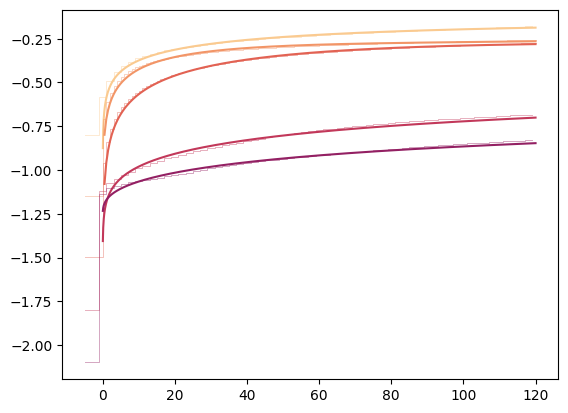

In [130]:
t_0 = 175
t_1 = 300
t_2 = 300
t_3 = 500
t_discharge0_fit_offset = 0.0
delta_discharge = 3

"""Fitting"""
init_guess = [50, 1e-1, 1e-1, 1e-2]
lower_limit = [0, 0, 0, 0]
upper_limit = [np.inf, np.inf, np.inf, np.inf]
maxfev = 1000
fit_results = []


"""Plotting"""
cmap = plt.get_cmap("cmo.matter")  # type:ignore
colors = cmap(np.linspace(0.1, 0.7, len(iviums)))


for i, (number) in enumerate(
    all_ivium.sort_values(by="E_applied", ascending=False)["number"].unique()
):
    """Fitting"""
    data_flim = all_ivium.query(
        f"number == @number and t_s >= @t_0 and t_s <= @t_1"
    ).copy()

    if data_flim.t_s.size > 1000:
        n = 40
    else:
        n = 2

    x_t = data_flim.query(
        f"(t_discharge0 >= @t_discharge0_fit_offset) and (t_s < @t_1)"
    ).t_discharge0
    y_E = data_flim.query(
        f"(t_discharge0 >= @t_discharge0_fit_offset) and (t_s < @t_1)"
    ).Delta_E

    x_eval = np.linspace(0, t_discharge0 - t_discharge0_fit_offset, int(1e4))
    y_eval = np.interp(x_eval, x_t, y_E)

    params, covs = optimize.curve_fit(
        discharging_potential,
        x_eval[n:],
        y_eval[n:],
        p0=init_guess,
        method="trf",
        bounds=[lower_limit, upper_limit],
        maxfev=maxfev,
    )
    print(params)
    data_flim["tau"] = params[0]
    data_flim["a"] = params[1]
    data_flim["b"] = params[2]
    data_flim["c"] = params[3]

    """Re apply fit results"""
    data_flim["Delta_E_fit"] = discharging_potential(data_flim.t_discharge0, *params)
    r2 = r2_score(y_eval[n:], discharging_potential(x_eval[n:], *params))
    data_flim["r2"] = r2

    data_flim["E_V_fit"] = (
        data_flim.Delta_E_fit + data_flim.query("t_discharge0 >= 0").E_V.values[0]
    )

    data_flim["Delta_E_electrolytic"] = discharging_potential(
        data_flim.t_discharge0, params[0], params[1], 0, 0
    )
    data_flim["E_V_fit_electrolytic"] = (
        data_flim.Delta_E_electrolytic + data_flim.E_applied
    )
    data_flim["Delta_E_faradaic"] = discharging_potential(
        data_flim.t_discharge0, params[0], 0, params[2], 0
    )
    data_flim["E_V_fit_faradaic"] = data_flim.Delta_E_faradaic + data_flim.E_applied
    data_flim["Delta_E_redistribution"] = discharging_potential(
        data_flim.t_discharge0, params[0], 0, 0, params[3]
    )
    data_flim["E_V_fit_redistribution"] = (
        data_flim.Delta_E_redistribution + data_flim.E_applied
    )

    fit_results.append(data_flim)

    plt.step(
        data_flim.t_discharge0.values[::n],
        data_flim["E_V"].values[::n],
        color=colors[i],
        alpha=0.4,
        lw=0.7,
    )
    plt.plot(data_flim.t_discharge0, data_flim["E_V_fit"], color=colors[i])


results_discharge = pd.concat(fit_results)
results_discharge.head()

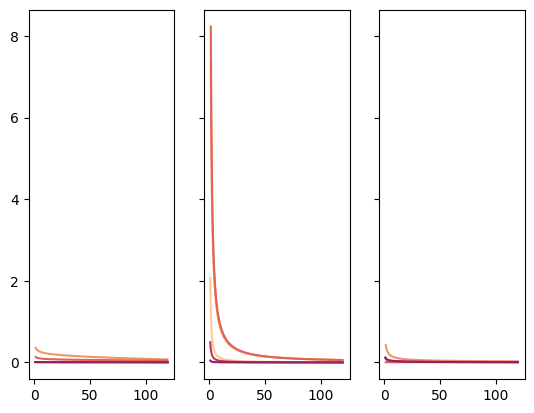

In [126]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
for i, (number) in enumerate(
    results_discharge.sort_values(by="E_applied", ascending=False)["number"].unique()
):
    results = results_discharge.query(f"number == @number and Delta_E_faradaic > 0")
    ax = axes.ravel()[0]
    # ax.set_ylim(-0.1, 100)
    ax.plot(
        results.t_discharge0[:-1],
        -100 * np.diff(results.Delta_E_electrolytic) / results.Delta_E_fit.values[:-1],
        color=colors[i],
    )

    ax = axes.ravel()[1]
    ax.plot(
        results.t_discharge0[:-1],
        100 * np.diff(results.Delta_E_faradaic) / results.Delta_E_fit.values[:-1],
        color=colors[i],
    )
    ax = axes.ravel()[2]
    ax.plot(
        results.t_discharge0[:-1],
        100
        * np.diff(results.Delta_E_redistribution)
        / results.Delta_E_fit.values[:-1],
        color=colors[i],
    )
plt.show()

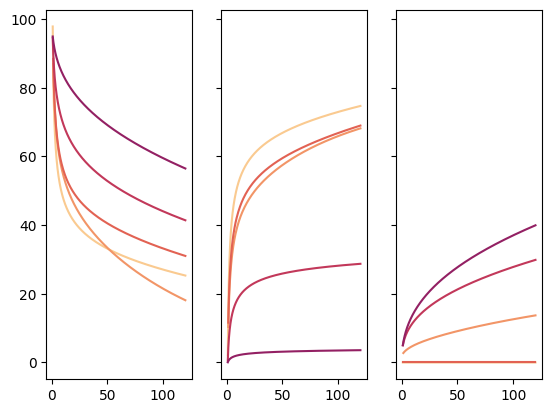

In [128]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
for i, (number) in enumerate(
    results_discharge.sort_values(by="E_applied", ascending=False)["number"].unique()
):
    results = results_discharge.query(f"number == @number and Delta_E_faradaic > 0")
    ax = axes.ravel()[0]
    # ax.set_ylim(-0.1, 100)
    ax.plot(
        results.t_discharge0,
        100 * results.Delta_E_electrolytic / results.Delta_E_fit,
        color=colors[i],
    )

    ax = axes.ravel()[1]
    ax.plot(
        results.t_discharge0,
        100 * results.Delta_E_faradaic / results.Delta_E_fit,
        color=colors[i],
    )
    ax = axes.ravel()[2]
    ax.plot(
        results.t_discharge0,
        100 * results.Delta_E_redistribution / results.Delta_E_fit,
        color=colors[i],
    )
plt.show()

# Extract pHs

In [5]:
flim_data = []
for ivium in iviums:
    flim_data.append(
        fp.open_flim(
            ivium["path"].split(".")[0] + "_old_p.npz",
            property_modifications={"lifetime_phase": 1000, "value": 1000},
        )
    )

In [6]:
extent = fa.get_extent(flim_data[0]["value"][0], 9.09, 1e-3)
print(extent)
geom_extent = [
    0,
    flim_data[0]["intensity"][0].shape[1],
    0,
    flim_data[0]["intensity"][0].shape[0],
]
print(geom_extent)
features01 = fg.load_features(
    folder,
    "capacitance_ivium1395_1p3_features.shp",
    "capacitance_ivium1395_1p3_features.npz",
)
features02 = fg.load_features(
    folder,
    "capacitance_ivium1465_1p8_features.shp",
    "capacitance_ivium1465_1p8_features.npz",
)

[0.      4.65408 0.      4.19958]
[0, 512, 0, 462]


In [7]:
masks = []

for i, flim in enumerate(flim_data):
    if iviums[i]["number"] in [1395, 1401, 1408]:
        features = features01
    else:
        features = features02
    particle = [f for f in features if f.name == "particle"][0]
    p = particle.geometry
    p_buffered = p.buffer(5)
    ring = p_buffered.difference(p)
    centroid = p.centroid
    bottom_half = Polygon(
        [
            (ring.bounds[0], centroid.y),
            (ring.bounds[0], ring.bounds[3]),
            (ring.bounds[2], ring.bounds[3]),
            (ring.bounds[2], centroid.y),
        ]
    )
    top_half = Polygon(
        [
            (ring.bounds[0], centroid.y),
            (ring.bounds[0], ring.bounds[1]),
            (ring.bounds[2], ring.bounds[1]),
            (ring.bounds[2], centroid.y),
        ]
    )
    top_ring = ring.difference(bottom_half)
    bottom_ring = ring.difference(top_half)
    rings = [top_ring, bottom_ring]
    ring_masks = []
    for ring in rings:
        mask = np.zeros([geom_extent[3], geom_extent[1]])
        points = [[x, y] for x, y in zip(*ring.boundary.coords.xy)]
        mask = cv2.fillPoly(mask, np.array([points]).astype(np.int32), color=1) # type:ignore
        ring_masks.append(mask)
    masks.append(ring_masks)

In [36]:
phs = []
ph_shift = {1408: 1.05, 1395: 1.3, 1401: 1.8, 1465: 0.5, 1467: 0}
for i, (flim, mask) in enumerate(zip(flim_data, masks)):
    top_phs = []
    bottom_phs = []

    for i_frame, frame in enumerate(list(flim["value"])):
        bottom_masked = frame * mask[1]
        bottom_phs.append(bottom_masked[bottom_masked > 0].mean())
        top_masked = frame * mask[0]
        top_phs.append(top_masked[top_masked > 0].mean())

    top_phs = np.array(top_phs) 
    bottom_phs = np.array(bottom_phs)
    mean_phs = (top_phs + bottom_phs) / 2 + ph_shift[iviums[i]["number"]]
    phs.append(
        {
            "number": iviums[i]["number"],
            "top": top_phs,
            "bottom": bottom_phs,
            "mean": mean_phs,
        }
    )

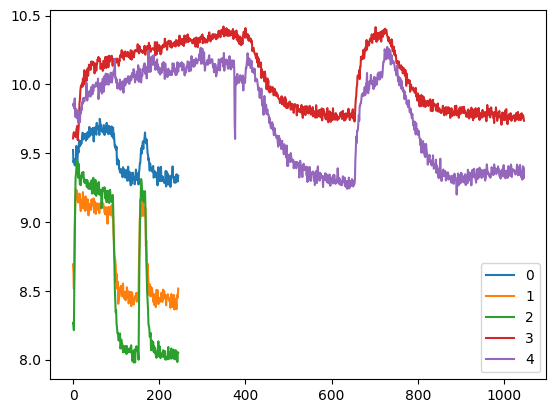

In [37]:
fig, ax = plt.subplots()
for i, (flim, ph) in enumerate(zip(flim_data, phs)):
    ax.plot(ph["mean"], label = i)
ax.legend()
plt.show()